In [222]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import requests
import tensorflow as tf
import time
import json
from datetime import datetime
from tensorflow import keras
from tensorflow.keras import layers
import tensorflowjs as tfjs
from tool import plot_history, readFile, buildModel, PrintDot

In [223]:
data = []
# dailyData = pd.json_normalize(readFile('dailies'))
dailyData = readFile('dailies')

for item in dailyData:
  if item.get('startTime') and item.get('startTime') != '09:00' and item.get('startTime') != '10:00':
    startTime = item['startTime']
    dateTimex = time.mktime(time.strptime(item['date'] + ' 00:00:00', '%Y-%m-%d %H:%M:%S'))
    startTimex = time.mktime(time.strptime(item['date'] + ' ' + item['startTime'], '%Y-%m-%d %H:%M:%S'))
    moonTimex = time.mktime(time.strptime(item['date'] + ' ' + '15:00:00', '%Y-%m-%d %H:%M:%S'))
    endTimex = time.mktime(time.strptime(item['date'] + ' ' + item['endTime'], '%Y-%m-%d %H:%M:%S'))
    countTimex = endTimex - startTimex
    week =  datetime.strptime(item['date'], "%Y-%m-%d").isoweekday()

    isMonday = week == 1
    isWorkday = week == 2 or week == 3 or week == 4
    isFriday = week == 5
    isSatday = week == 6
    isSunday = week == 7

    tickets = item.get('tickets')
 
    if (tickets.get('price') and tickets.get('available')):
      price = item['tickets']['price'] / 1000
      yearcardDay = int(pd.array(item['tickets']['available']).size > 1)
      available = pd.array(item['tickets']['available']).size / 4
      for row in item['rows']:
        timex = (row[0] - startTimex) / countTimex
        data.append({"timex": timex, 
          "value": row[1], 
          "max": item["max"], 
          "moonTimex": (row[0] - startTimex) / (moonTimex - startTimex), 
          "park": item["park"], 
          "date": item["date"], 
          "median": 0, 
          "week": week, 
          "price": price, 
          "available": available, 
          "isMonday": int(isMonday),
          "isWorkday": int(isWorkday), 
          "isFriday": int(isFriday), 
          "isSatday": int(isSatday), 
          "isSunday": int(isSunday),
          "yearcardDay": yearcardDay
        })

In [224]:
dataset = pd.json_normalize(data)

dataset = dataset[(dataset['value'] > 0) & (dataset['max'] > 0)]
dataset = dataset[dataset['moonTimex'] < 1]

dataset["timex"] = dataset["moonTimex"]

dateGroups = dataset.groupby('date')

nData = []
for date, group in dateGroups:
  median = group['value'].median()
  p90 = group['value'].quantile(0.9)
  p50 = group['value'].quantile(0.5)
  for index, item in group.iterrows():
    nData.append({
      "timex": item['timex'], 
      "p90": p90, 
      "p50": p50, 
      "value": item["value"], 
      "park": item["park"], 
      "week": item["week"], 
      "price": item["price"], 
      "available": item["available"], 
      "isMonday": item["isMonday"], 
      "isWorkday": item["isWorkday"], 
      "isFriday": item["isFriday"], 
      "isSatday": item["isSatday"], 
      "isSunday": item["isSunday"],
      "yearcardDay": item["yearcardDay"],
    })

dataset = pd.json_normalize(nData)
dataset['value'] = dataset['value'] / 2000
dataset['p90'] = dataset['p90'] / 2000
dataset['p50'] = dataset['p50'] / 2000

# dataset = dataset[dataset['p90'] > 0.5]

dataset


,timex,p90,p50,value,park,week,price,available,isMonday,isWorkday,isFriday,isSatday,isSunday,yearcardDay
0,0.012821,0.11380,0.0910,0.0345,shdr,6,0.599,0.5,0,0,0,1,0,1
1,0.025641,0.11380,0.0910,0.0490,shdr,6,0.599,0.5,0,0,0,1,0,1
2,0.038462,0.11380,0.0910,0.0500,shdr,6,0.599,0.5,0,0,0,1,0,1
3,0.051282,0.11380,0.0910,0.0500,shdr,6,0.599,0.5,0,0,0,1,0,1
4,0.064103,0.11380,0.0910,0.0500,shdr,6,0.599,0.5,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23072,0.916667,0.94475,0.5775,0.2700,usb,2,0.638,0.5,0,1,0,0,0,1
23073,0.933333,0.94475,0.5775,0.2645,usb,2,0.638,0.5,0,1,0,0,0,1
23074,0.950000,0.94475,0.5775,0.2700,usb,2,0.638,0.5,0,1,0,0,0,1
23075,0.966667,0.94475,0.5775,0.2645,usb,2,0.638,0.5,0,1,0,0,0,1


In [225]:
def generParkData(data, name):
  # dataset = data[data['park'] == name]
  dataset = data[data['park'] == name]
  print(dataset.count())
  plot_cols = ['p90']
  plot_features = dataset[plot_cols]
  plot_features.index = dataset['timex']
  _ = plot_features.plot()

  dataset = dataset[['value', 'p90', 'timex', 'price', 'yearcardDay', 'isMonday', 'isSatday', 'isSunday', 'isFriday', 'available']]
  # dataset = dataset[1:]

  print(dataset.head())
  
  # 拆分训练数据集和测试数据集
  train_dataset = dataset.sample(frac=0.9,random_state=0)
  test_dataset = dataset.drop(train_dataset.index)
  dataset.drop(train_dataset.index)

  train_stats = train_dataset.describe()
  train_stats.pop("p90")
  train_stats = train_stats.transpose()
  # train_stats

  # 从标签中分离特征
  train_labels = train_dataset.pop('p90')
  test_labels = test_dataset.pop('p90')

  normed_train_data = train_dataset
  normed_test_data = test_dataset

  return [normed_train_data, normed_test_data, train_dataset, train_labels, test_labels]



timex          15286
p90            15286
p50            15286
value          15286
park           15286
week           15286
price          15286
available      15286
isMonday       15286
isWorkday      15286
isFriday       15286
isSatday       15286
isSunday       15286
yearcardDay    15286
dtype: int64
    value     p90     timex  price  yearcardDay  isMonday  isSatday  isSunday  \
0  0.0345  0.1138  0.012821  0.599            1         0         1         0   
1  0.0490  0.1138  0.025641  0.599            1         0         1         0   
2  0.0500  0.1138  0.038462  0.599            1         0         1         0   
3  0.0500  0.1138  0.051282  0.599            1         0         1         0   
4  0.0500  0.1138  0.064103  0.599            1         0         1         0   

   isFriday  available  
0         0        0.5  
1         0        0.5  
2         0        0.5  
3         0        0.5  
4         0        0.5  
Model: "sequential_61"
_________________________________

/Users/fanbokong/Library/Python/3.9/lib/python/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

/Users/fanbokong/Library/Python/3.9/lib/python/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]



....................................................................

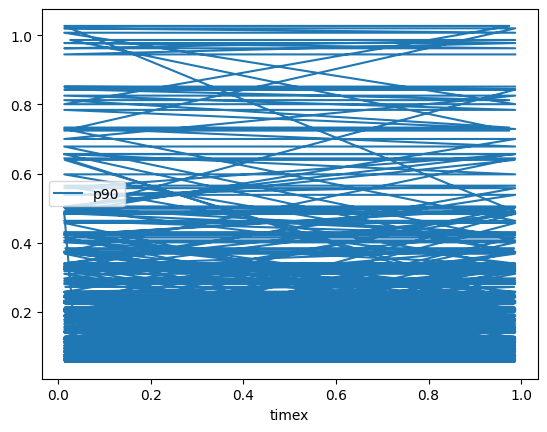

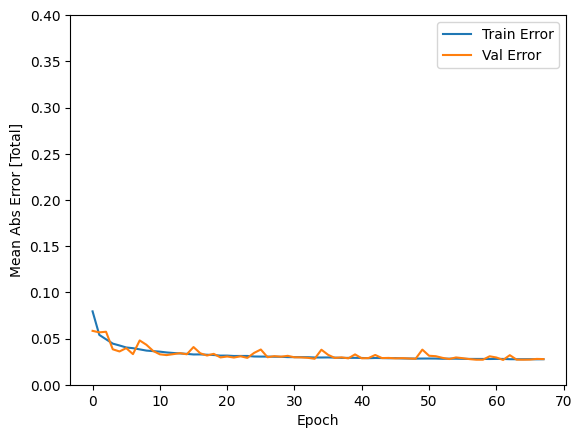

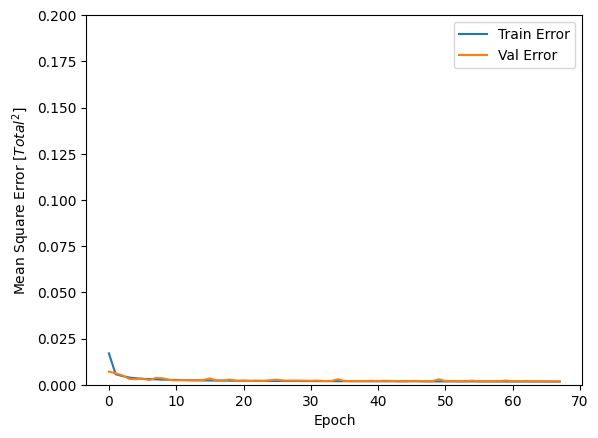

48/48 [==============================] - 0s 329us/step


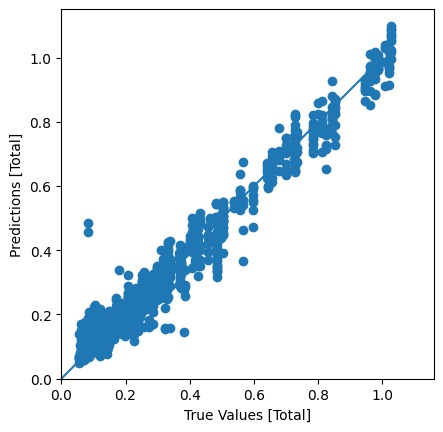

In [227]:
def start(name):
  [normed_train_data, normed_test_data, train_dataset, train_labels, test_labels] = generParkData(dataset, name)
  model = buildModel(train_dataset)
  model.summary()

  example_batch = normed_train_data[:10]
  example_result = model.predict(example_batch)
  # return
  EPOCHS = 5000

  history = model.fit(
    normed_train_data, train_labels,
    epochs=EPOCHS, validation_split = 0.2, verbose=0,
    callbacks=[PrintDot()])

  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  hist.tail()
  # plot_history(history)

  model = buildModel(train_dataset)
  # patience 值用来检查改进 epochs 的数量
  early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
  history = model.fit(normed_train_data, train_labels, epochs=EPOCHS, validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])
  plot_history(history)

  model.save('../model/' + name + '.h5')
  tfjs.converters.save_keras_model(model, '../web-model/' + name)

  # 做预测
  # testData = pd.json_normalize([])
  # testData['timex'] =  pd.RangeIndex(1, 100) / 100 * 0.5
  # testData['max'] = 0.9
  # print(testData.head())

  # test_predictions = model.predict(testData).flatten()
  # print(test_predictions)
  # testData['value'] = test_predictions # * 150

  # plot_cols = ['timex', 'value']
  # plot_features = testData[plot_cols]
  # plot_features.index = testData['timex']
  # _ = plot_features.plot()

  test_predictions = model.predict(normed_test_data).flatten()
  plt.scatter(test_labels, test_predictions)
  
  plt.xlabel('True Values [Total]')
  plt.ylabel('Predictions [Total]')
  plt.axis('equal')
  plt.axis('square')
  plt.xlim([0,plt.xlim()[1]])
  plt.ylim([0,plt.ylim()[1]])
  _ = plt.plot([-1, 1], [-1, 1])

parks = ['shdr']
for name in parks:
  start(name)